In [49]:
import numpy as np 
import pandas as pd

import librosa as lb
import os 
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import joblib

In [17]:
data = pd.read_csv('/home/pistovia/Projects/birdgo/mark two/audio/bird_songs_metadata.csv')
data.columns

Index(['id', 'genus', 'species', 'subspecies', 'name', 'recordist', 'country',
       'location', 'latitude', 'longitude', 'altitude', 'sound_type',
       'source_url', 'license', 'time', 'date', 'remarks', 'filename'],
      dtype='object')

In [37]:
data['name'].value_counts()

name
Song Sparrow            1256
Northern Mockingbird    1182
Northern Cardinal       1074
American Robin          1017
Bewick's Wren            893
Name: count, dtype: int64

In [18]:

audio = data[["filename","name"]]
audio.to_csv('audio.csv',index=False)

In [19]:
def feature_extract(filename):
    y,sr = lb.load(filename)
    feats = []

    # MFCC mean + std
    mfcc = lb.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    feats.extend(np.mean(mfcc, axis=1))
    feats.extend(np.std(mfcc, axis=1))

    # Spectral features (mean + std)
    centroid = lb.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = lb.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = lb.feature.spectral_rolloff(y=y, sr=sr)
    zcr = lb.feature.zero_crossing_rate(y)

    feats.append(np.mean(centroid))
    feats.append(np.std(centroid))
    feats.append(np.mean(bandwidth))
    feats.append(np.std(bandwidth))
    feats.append(np.mean(rolloff))
    feats.append(np.std(rolloff))
    feats.append(np.mean(zcr))
    feats.append(np.std(zcr))

    return feats

In [24]:
df = pd.read_csv('audio.csv')

features = []
for index,row in df.iterrows():
    feats = feature_extract(f"/home/pistovia/Projects/birdgo/mark two/audio/wavfiles/{row['filename']}")
    features.append(feats)

features_df = pd.DataFrame(features)

features_df['label']= df['name']

features_df.to_csv('audio.csv',index=False)



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

df = pd.read_csv('audio.csv')
species_list = df['label']  

# 1. Fit encoder
le = LabelEncoder()
le.fit(species_list)

# 2. Save encoder
with open("label_encoder.pkl", "wb") as f:
    joblib.dump(le, f)


In [22]:
result = feature_extract("/home/pistovia/Projects/birdgo/mark two/audio/wavfiles/557838-0.wav")
print(result)


[np.float32(-132.85225), np.float32(81.1399), np.float32(17.018223), np.float32(54.974297), np.float32(-10.344644), np.float32(24.57735), np.float32(3.0749779), np.float32(19.33934), np.float32(5.271629), np.float32(15.171051), np.float32(-0.0724389), np.float32(7.5691247), np.float32(10.887994), np.float32(31.741152), np.float32(32.083015), np.float32(10.278401), np.float32(22.26538), np.float32(23.349983), np.float32(14.867031), np.float32(9.218611), np.float32(6.5514503), np.float32(5.62511), np.float32(6.0531044), np.float32(4.4534764), np.float32(5.7964573), np.float32(5.595377), np.float64(2441.04428556101), np.float64(1054.6234275379811), np.float64(2378.701866439892), np.float64(180.31139263120292), np.float64(4716.185584435096), np.float64(1224.8380491354833), np.float64(0.11844200721153846), np.float64(0.10443922028033804)]


In [27]:
columns = []

# MFCCs (13 means + 13 stds)
columns += [f'mfcc_{i+1}_mean' for i in range(13)]
columns += [f'mfcc_{i+1}_std' for i in range(13)]

# Spectral features
columns += [
    'centroid_mean', 'centroid_std',
    'bandwidth_mean', 'bandwidth_std',
    'rolloff_mean', 'rolloff_std',
    'zcr_mean', 'zcr_std'
]
features_df = pd.DataFrame(features, columns=columns)
features_df['label'] = df['name']   
features_df.to_csv('audio.csv', index=False)    

In [60]:
df = pd.read_csv('audio.csv')

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RidgeClassifier()
model.fit(X_train, y_train)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred_rfc = classifier.predict(X_test)

y_pred = model.predict(X_test)
print("Ridge Classifier:")
print(y_pred)
print(classification_report(y_test , y_pred))
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rfc))


Ridge Classifier:
['Northern Cardinal' 'Northern Cardinal' 'Song Sparrow' ...
 'Northern Mockingbird' 'Song Sparrow' 'Song Sparrow']
                      precision    recall  f1-score   support

      American Robin       0.65      0.79      0.71       207
       Bewick's Wren       0.71      0.56      0.62       193
   Northern Cardinal       0.72      0.75      0.73       204
Northern Mockingbird       0.73      0.51      0.60       238
        Song Sparrow       0.63      0.77      0.70       243

            accuracy                           0.68      1085
           macro avg       0.69      0.68      0.67      1085
        weighted avg       0.69      0.68      0.67      1085

Random Forest Classifier:
                      precision    recall  f1-score   support

      American Robin       0.92      0.94      0.93       207
       Bewick's Wren       0.92      0.87      0.89       193
   Northern Cardinal       0.92      0.90      0.91       204
Northern Mockingbird       0.95

In [57]:

joblib.dump(model, "ridge_bird_model.pkl")

joblib.dump(classifier, "random_forest_bird_model.pkl")
joblib.dump(scaler, "feature_scaler.pkl")


['feature_scaler.pkl']

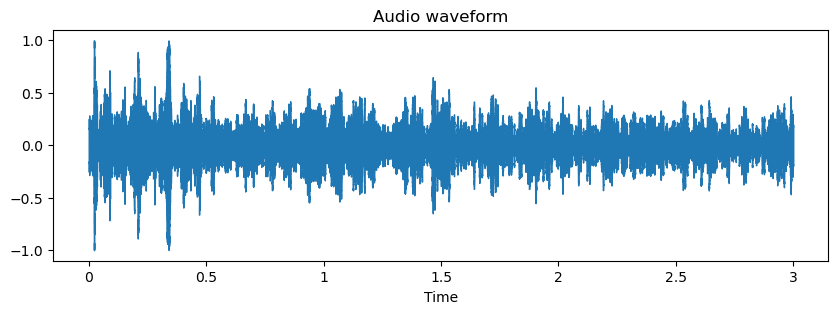

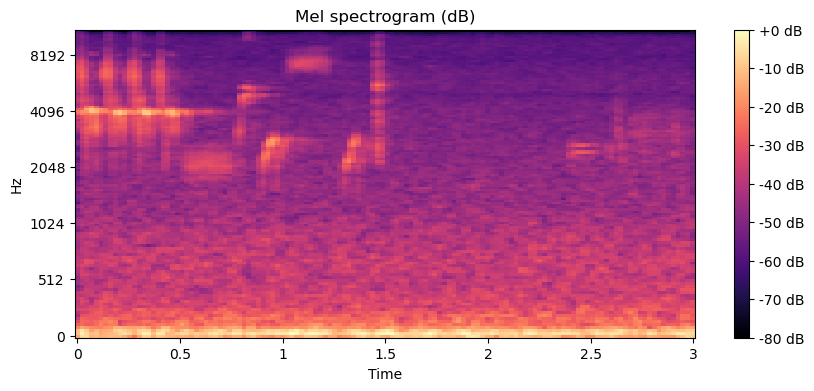

In [42]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

y, sr = librosa.load("/home/pistovia/Projects/birdgo/mark two/audio/wavfiles/557836-11.wav", duration=3)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio waveform")
plt.show()

mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.title("Mel spectrogram (dB)")
plt.colorbar(format="%+2.0f dB")
plt.show()


In [ ]:
# pip install plotly  # if needed
import plotly.io as pio
pio.renderers.default = 'browser'
fig.show()
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd

X = df.drop('label', axis=1)
y = df['label']

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=['PC1','PC2','PC3'])
pca_df['label'] = y.values

fig = px.scatter_3d(
    pca_df,
    x='PC1', y='PC2', z='PC3',
    color='label',
    symbol='label',        # optional: different markers per label
    hover_data={'PC1':True, 'PC2':True, 'PC3':True},
    title='Interactive 3D PCA',
    width=900, height=700
)

fig.update_traces(marker=dict(size=4))  # adjust point size
fig.show()

# To save as standalone HTML:
fig.write_html("pca_3d_interactive.html")


ModuleNotFoundError: No module named 'matplotlib'

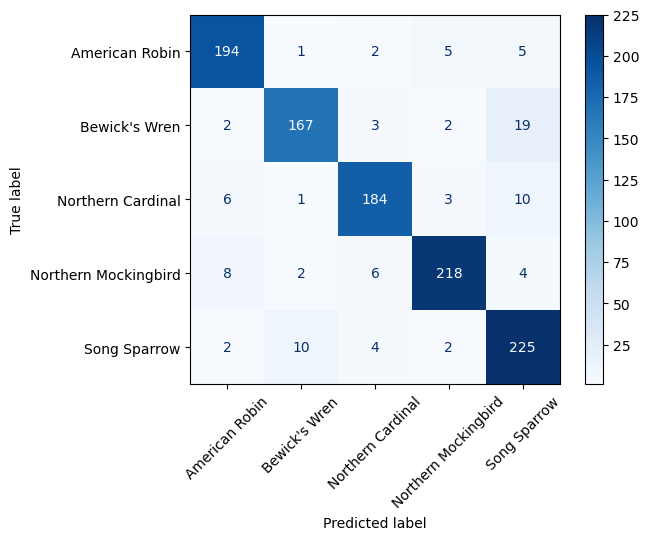

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

NameError: name 'model' is not defined

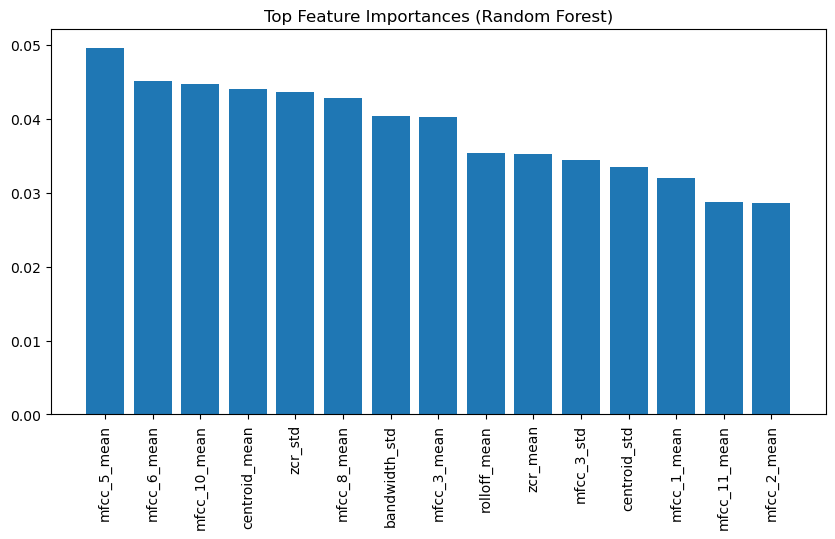

In [53]:
import numpy as np
import matplotlib.pyplot as plt

importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Top Feature Importances (Random Forest)")
plt.bar(range(15), importances[indices][:15])
plt.xticks(range(15), np.array(X.columns)[indices][:15], rotation=90)
plt.show()


In [56]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores_rfc = cross_val_score(classifier, X, y, cv=5)
print("Cross-validation accuracy:", scores.mean())
print("Random Forest Cross-validation accuracy:", scores_rfc.mean())


Cross-validation accuracy: 0.5894570374275171
Random Forest Cross-validation accuracy: 0.5855964426003707
